‚úÖ Best model detected: XGB
üìÑ Model path: /home/swateya_gupta/2/model_registry/xgb_churn_model.pkl


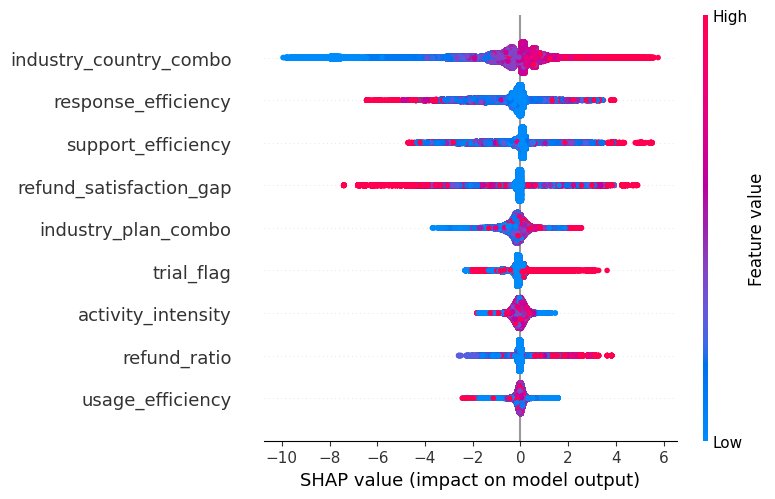

<Figure size 640x480 with 0 Axes>

üîç Local SHAP Explanation for sample 126439


‚≠ê Top 5 SHAP-driven features: ['industry_plan_combo', 'refund_satisfaction_gap', 'support_efficiency', 'response_efficiency', 'industry_country_combo']


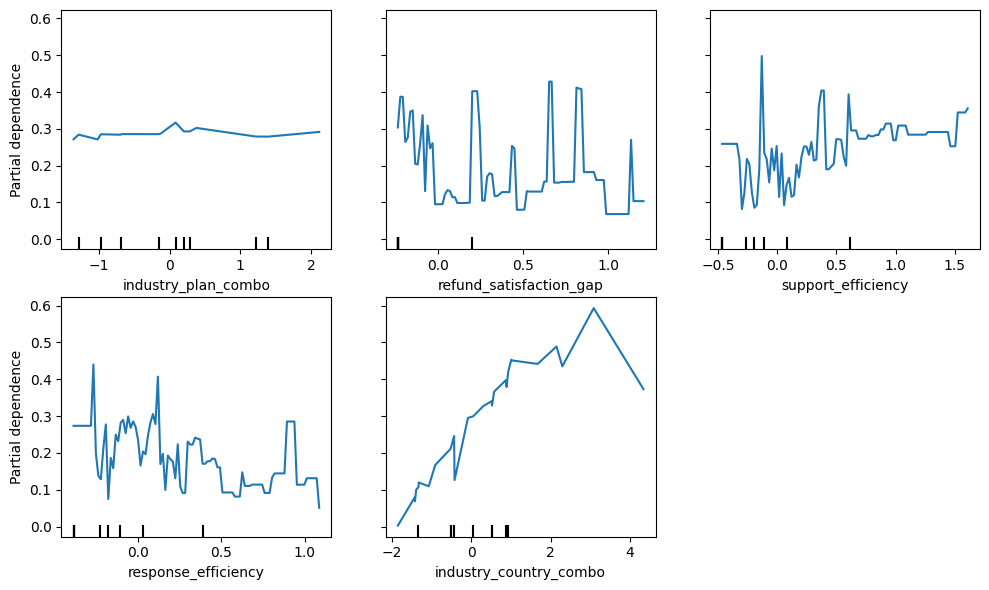

In [3]:
# ==============================================================
# 04_model_explainability.ipynb
# ==============================================================

import pandas as pd, numpy as np, os, joblib, shap, matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# --------------------------------------------------------------
# Correct Paths
# --------------------------------------------------------------
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_path = os.path.join(root_dir, "data", "processed", "engineered_features_final.csv")
encoder_path = os.path.join(root_dir, "model_registry", "encoder.pkl")
scaler_path = os.path.join(root_dir, "model_registry", "scaler.pkl")
log_path = os.path.join(root_dir, "model_registry", "experiments_log.csv")

# Detect which model performed best
exp_df = pd.read_csv(log_path)
best_model_name = exp_df.sort_values("roc_auc", ascending=False).iloc[0]["model"]
model_path = os.path.join(root_dir, "model_registry", f"{best_model_name}_churn_model.pkl")

print(f"‚úÖ Best model detected: {best_model_name.upper()}")
print(f"üìÑ Model path: {model_path}")

# --------------------------------------------------------------
# Load artifacts
# --------------------------------------------------------------
df = pd.read_csv(data_path)
model = joblib.load(model_path)
encoder = joblib.load(encoder_path)
scaler = joblib.load(scaler_path)

X = df.drop(columns=["account_id", "account_churn_flag"], errors="ignore")
y = df["account_churn_flag"]

# --- Encode categorical variables (to match training) ---
cat_cols = [c for c in ["industry_country_combo", "industry_plan_combo"] if c in X.columns]
if len(cat_cols) > 0:
    X_te = encoder.transform(X[cat_cols])
    X = pd.concat([X.drop(columns=cat_cols), X_te], axis=1)

# --- Scale ---
X_scaled = scaler.transform(X)
X_df = pd.DataFrame(X_scaled, columns=X.columns)


# --------------------------------------------------------------
# 1Ô∏è‚É£ Global Explainability ‚Äî SHAP Summary
# --------------------------------------------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_df)

shap.summary_plot(shap_values, X_df, show=True)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 2Ô∏è‚É£ Local Explainability ‚Äî Random Example
# --------------------------------------------------------------
sample_idx = np.random.randint(0, len(X_df))
print(f"üîç Local SHAP Explanation for sample {sample_idx}")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample_idx, :], X_df.iloc[sample_idx, :])

# --------------------------------------------------------------
# 3Ô∏è‚É£ Partial Dependence ‚Äî Top 5 Important Features
# --------------------------------------------------------------
top_features = np.argsort(np.abs(shap_values).mean(0))[-5:]
selected = [X_df.columns[i] for i in top_features]
print("‚≠ê Top 5 SHAP-driven features:", selected)

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(model, X_df, selected, ax=ax)
plt.tight_layout()
plt.show()


In [4]:
# ==============================================================
# 4Ô∏è‚É£ GLOBAL & SEGMENT-LEVEL SHAP SUMMARIES
# ==============================================================

import pandas as pd
import numpy as np

# ---- Global Importance Summary ----
print("üìä Computing global SHAP importance summary...")

# Compute mean absolute SHAP value per feature
shap_importance = pd.DataFrame({
    "feature": X_df.columns,
    "mean_abs_shap": np.abs(shap_values).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False)

# Save & display
global_shap_path = os.path.join(root_dir, "model_registry", "global_shap_importance.csv")
shap_importance.to_csv(global_shap_path, index=False)

print(f"‚úÖ Global SHAP importance table saved ‚Üí {global_shap_path}")
display(shap_importance.head(10))


# ---- Segment-Level (Industry √ó Country) SHAP Trends ----
if "industry_country_combo" in df.columns:
    print("\nüåç Computing segment-level SHAP trends by industry-country combo...")
    
    # Add SHAP sum per sample
    df_shap = df.copy()
    df_shap["total_shap_influence"] = shap_values.sum(axis=1)
    
    # Group by segment and compute mean SHAP
    segment_summary = (
        df_shap.groupby("industry_country_combo")["total_shap_influence"]
        .mean()
        .reset_index()
        .sort_values("total_shap_influence", ascending=False)
    )

    segment_path = os.path.join(root_dir, "model_registry", "segment_shap_trends.csv")
    segment_summary.to_csv(segment_path, index=False)

    print(f"‚úÖ Segment-level SHAP trends saved ‚Üí {segment_path}")
    display(segment_summary.head(10))
else:
    print("‚ö†Ô∏è Column 'industry_country_combo' not found ‚Äî skipping segment-level SHAP aggregation.")


üìä Computing global SHAP importance summary...
‚úÖ Global SHAP importance table saved ‚Üí /home/swateya_gupta/2/model_registry/global_shap_importance.csv


feature  mean_abs_shap
7   industry_country_combo       1.345012
5      response_efficiency       0.933390
4       support_efficiency       0.842267
3  refund_satisfaction_gap       0.437315
8      industry_plan_combo       0.301352
6               trial_flag       0.220161
1       activity_intensity       0.182237
2             refund_ratio       0.169809
0         usage_efficiency       0.121337


üåç Computing segment-level SHAP trends by industry-country combo...
‚úÖ Segment-level SHAP trends saved ‚Üí /home/swateya_gupta/2/model_registry/segment_shap_trends.csv


industry_country_combo  total_shap_influence
29          HealthTech_CA              3.365114
23             FinTech_DE              2.030085
9             DevTools_DE              1.485526
19              EdTech_UK              0.875775
12            DevTools_UK             -0.058766
1        Cybersecurity_CA             -0.243592
2        Cybersecurity_DE             -0.342749
13            DevTools_US             -0.560320
25             FinTech_IN             -0.567056
32          HealthTech_IN             -0.802858

üé® Generating SHAP influence heatmap across industries and countries...


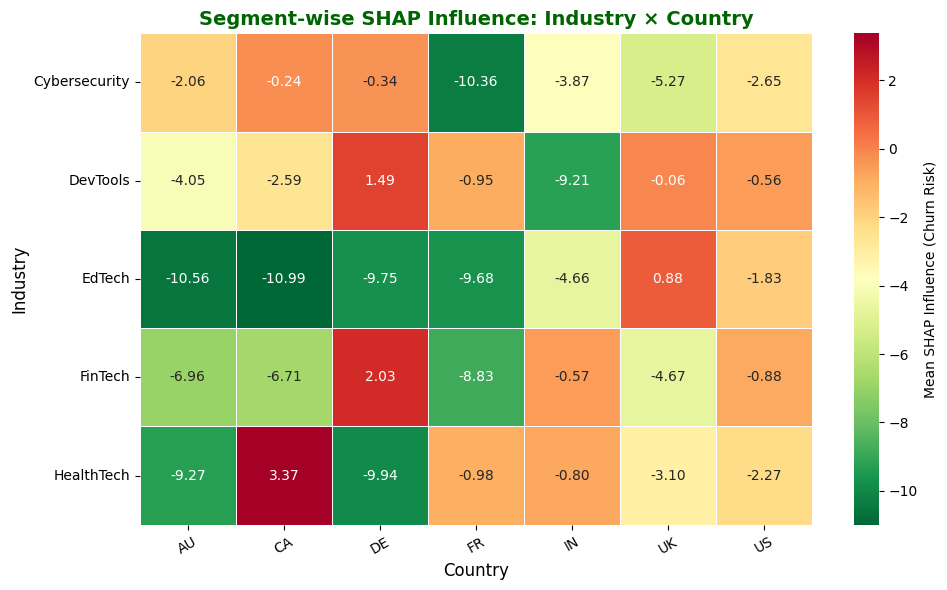

In [5]:
# ==============================================================
# 5Ô∏è‚É£ HEATMAP VISUALIZATION ‚Äì SHAP Influence by Industry & Country
# ==============================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("üé® Generating SHAP influence heatmap across industries and countries...")

# Split the combo into industry and country
if "industry_country_combo" in segment_summary.columns:
    seg_df = segment_summary.copy()
    seg_df[["industry", "country"]] = seg_df["industry_country_combo"].str.split("_", n=1, expand=True)

    # Pivot for heatmap
    heatmap_data = seg_df.pivot(index="industry", columns="country", values="total_shap_influence")

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_data,
        cmap="RdYlGn_r",
        annot=True,
        fmt=".2f",
        linewidths=0.7,
        cbar_kws={"label": "Mean SHAP Influence (Churn Risk)"},
    )
    plt.title("Segment-wise SHAP Influence: Industry √ó Country", fontsize=14, weight="bold", color="darkgreen")
    plt.xlabel("Country", fontsize=12)
    plt.ylabel("Industry", fontsize=12)
    plt.xticks(rotation=30)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("‚ö†Ô∏è 'industry_country_combo' not found in segment_summary ‚Äî heatmap skipped.")


üìä Generating efficiency vs churn heatmaps...


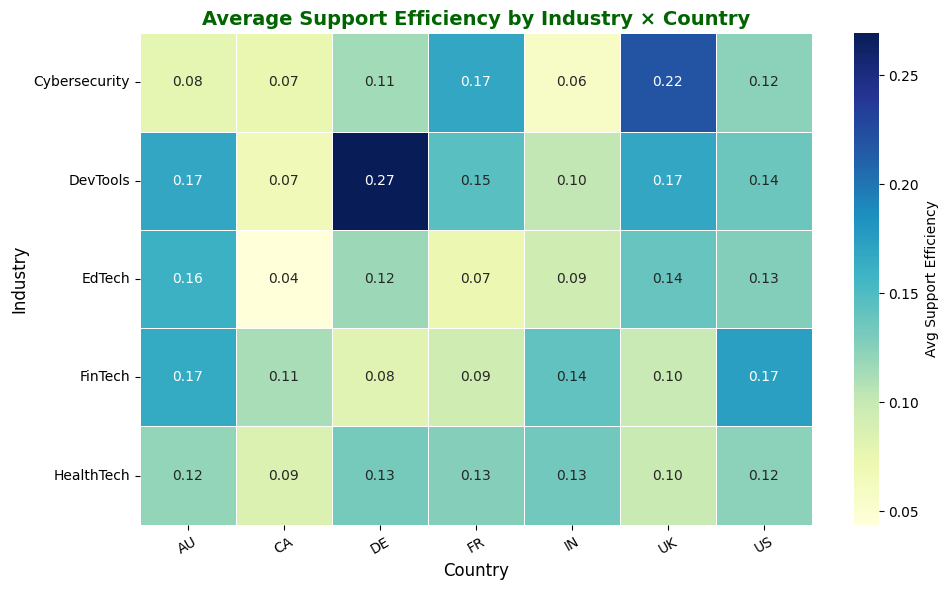

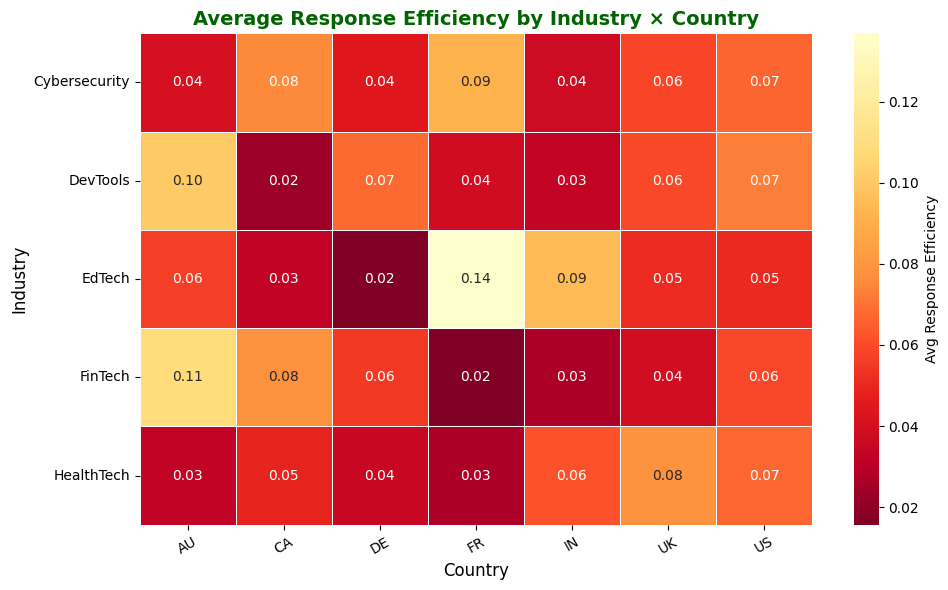

In [6]:
# ==============================================================
# 6Ô∏è‚É£ HEATMAPS ‚Äì Operational Efficiency vs Churn Explainability
# ==============================================================

print("üìä Generating efficiency vs churn heatmaps...")

# Ensure required columns exist
required_cols = {"industry_country_combo", "support_efficiency", "response_efficiency"}
if required_cols.issubset(df.columns):

    # Create segment averages for efficiency metrics
    efficiency_summary = (
        df.groupby("industry_country_combo")[["support_efficiency", "response_efficiency"]]
        .mean()
        .reset_index()
    )

    # Split into industry and country for heatmap pivots
    efficiency_summary[["industry", "country"]] = efficiency_summary["industry_country_combo"].str.split("_", n=1, expand=True)

    # Heatmap 1: Support Efficiency
    plt.figure(figsize=(10, 6))
    heatmap_support = efficiency_summary.pivot(index="industry", columns="country", values="support_efficiency")
    sns.heatmap(
        heatmap_support,
        cmap="YlGnBu",
        annot=True,
        fmt=".2f",
        linewidths=0.7,
        cbar_kws={"label": "Avg Support Efficiency"},
    )
    plt.title("Average Support Efficiency by Industry √ó Country", fontsize=14, weight="bold", color="darkgreen")
    plt.xlabel("Country", fontsize=12)
    plt.ylabel("Industry", fontsize=12)
    plt.xticks(rotation=30)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Heatmap 2: Response Efficiency
    plt.figure(figsize=(10, 6))
    heatmap_response = efficiency_summary.pivot(index="industry", columns="country", values="response_efficiency")
    sns.heatmap(
        heatmap_response,
        cmap="YlOrRd_r",
        annot=True,
        fmt=".2f",
        linewidths=0.7,
        cbar_kws={"label": "Avg Response Efficiency"},
    )
    plt.title("Average Response Efficiency by Industry √ó Country", fontsize=14, weight="bold", color="darkgreen")
    plt.xlabel("Country", fontsize=12)
    plt.ylabel("Industry", fontsize=12)
    plt.xticks(rotation=30)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("‚ö†Ô∏è Missing one or more columns: support_efficiency, response_efficiency, industry_country_combo")


üìà Correlating SHAP churn influence with efficiency metrics...


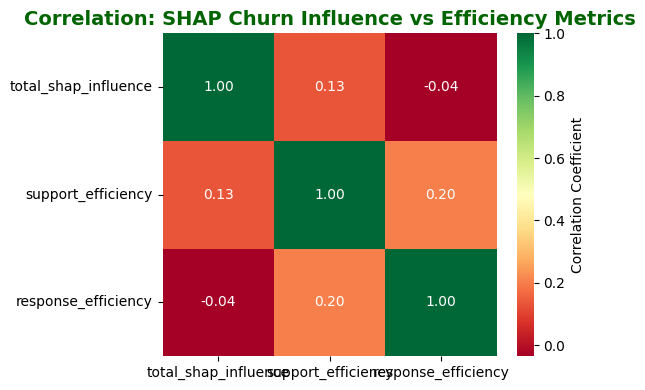

üîπ Correlation (SHAP vs Support Efficiency): 0.135
üîπ Correlation (SHAP vs Response Efficiency): -0.035
‚ö†Ô∏è Some regions may show higher churn despite efficiency ‚Äî investigate segment-level SHAPs.


In [7]:
# ==============================================================
# 7Ô∏è‚É£ CORRELATION: SHAP Churn Influence vs Efficiency Metrics
# ==============================================================

print("üìà Correlating SHAP churn influence with efficiency metrics...")

# Merge SHAP segment trends with efficiency summaries
if "segment_summary" in locals() and "efficiency_summary" in locals():
    merged_corr = pd.merge(
        segment_summary,
        efficiency_summary,
        on="industry_country_combo",
        how="inner"
    )

    # Compute correlation matrix
    corr_matrix = merged_corr[["total_shap_influence", "support_efficiency", "response_efficiency"]].corr()

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap="RdYlGn",
        fmt=".2f",
        cbar_kws={"label": "Correlation Coefficient"},
    )
    plt.title("Correlation: SHAP Churn Influence vs Efficiency Metrics", fontsize=14, weight="bold", color="darkgreen")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Print a quick interpretation summary
    corr_support = corr_matrix.loc["total_shap_influence", "support_efficiency"]
    corr_response = corr_matrix.loc["total_shap_influence", "response_efficiency"]

    print(f"üîπ Correlation (SHAP vs Support Efficiency): {corr_support:.3f}")
    print(f"üîπ Correlation (SHAP vs Response Efficiency): {corr_response:.3f}")

    if corr_support < 0 and corr_response < 0:
        print("‚úÖ Higher efficiency strongly reduces churn influence (negative correlation).")
    elif corr_support > 0 or corr_response > 0:
        print("‚ö†Ô∏è Some regions may show higher churn despite efficiency ‚Äî investigate segment-level SHAPs.")
else:
    print("‚ö†Ô∏è Required data not found ‚Äî ensure Step 5 & 6 were executed successfully.")


In [8]:
# ==============================================================
# 8Ô∏è‚É£ REGIONAL ANOMALY INSPECTION ‚Äì High Churn Despite High Efficiency
# ==============================================================

threshold_support = efficiency_summary["support_efficiency"].quantile(0.75)
threshold_shap = segment_summary["total_shap_influence"].quantile(0.75)

anomaly_segments = merged_corr[
    (merged_corr["support_efficiency"] >= threshold_support) &
    (merged_corr["total_shap_influence"] >= threshold_shap)
][["industry_country_combo", "support_efficiency", "response_efficiency", "total_shap_influence"]]

print("‚ö†Ô∏è Segments with high support efficiency but still high churn influence:")
display(anomaly_segments)


‚ö†Ô∏è Segments with high support efficiency but still high churn influence:


industry_country_combo  support_efficiency  response_efficiency  \
2            DevTools_DE            0.269101             0.068143   
4            DevTools_UK            0.168598             0.059308   

   total_shap_influence  
2              1.485526  
4             -0.058766

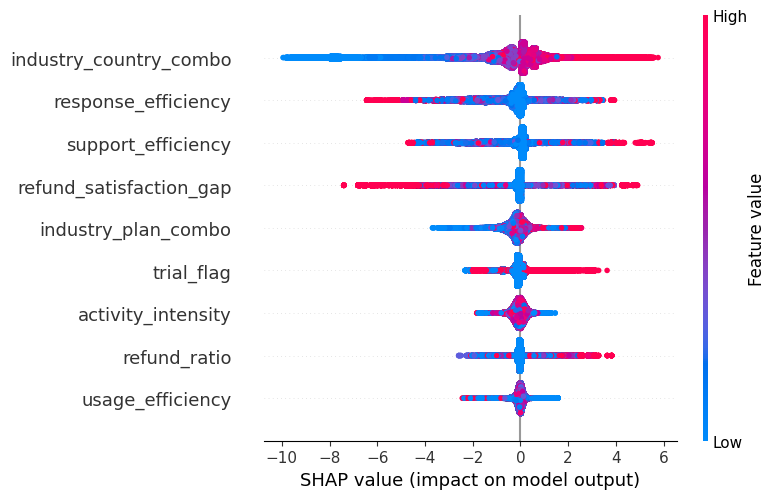

<Figure size 640x480 with 0 Axes>

‚≠ê Top 5 SHAP-driven features: ['industry_plan_combo', 'refund_satisfaction_gap', 'support_efficiency', 'response_efficiency', 'industry_country_combo']


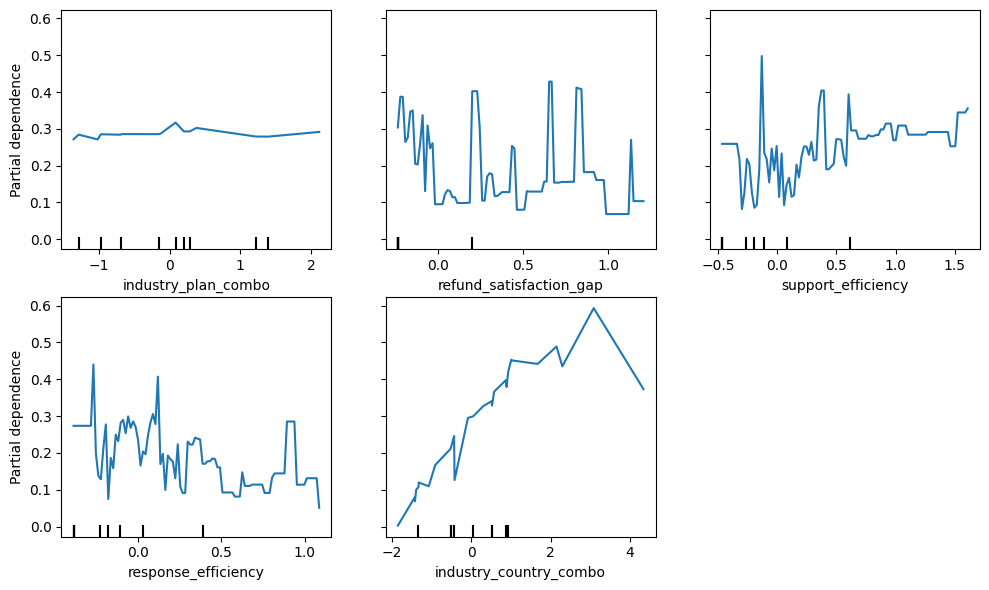

In [9]:
# --- SHAP helper to normalize output shape ---
def get_shap_values(trained_model, X_matrix):
    explainer = shap.TreeExplainer(trained_model)
    sv = explainer.shap_values(X_matrix)
    # For binary XGBoost/CatBoost, shap_values may be:
    # - array (n, f)  OR  list of 2 arrays [class0, class1]
    if isinstance(sv, list):
        sv = sv[1]  # positive class
    return explainer, sv

explainer, shap_values = get_shap_values(model, X_df)

# Global summary plot
shap.summary_plot(shap_values, X_df, show=True)
plt.tight_layout()
plt.show()

# PDP on top-5 SHAP features
top_idx = np.argsort(np.abs(shap_values).mean(0))[-5:]
selected = [X_df.columns[i] for i in top_idx]
print("‚≠ê Top 5 SHAP-driven features:", selected)

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(model, X_df, selected, ax=ax)
plt.tight_layout()
plt.show()


In [10]:
# GLOBAL: mean |SHAP| per feature
global_imp = pd.DataFrame({
    "feature": X_df.columns,
    "mean_abs_shap": np.abs(shap_values).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False)

mr = os.path.join(root_dir, "model_registry")
os.makedirs(mr, exist_ok=True)

# your existing name
global_path_legacy = os.path.join(mr, "global_shap_importance.csv")
# name the dashboard expects
global_path_canonical = os.path.join(mr, "shap_feature_importance.csv")

global_imp.to_csv(global_path_legacy, index=False)
global_imp.rename(columns={"mean_abs_shap":"importance"}).to_csv(global_path_canonical, index=False)

print(f"‚úÖ Saved global SHAP ‚Üí {global_path_legacy}")
print(f"‚úÖ Saved dashboard importances ‚Üí {global_path_canonical}")
display(global_imp.head(10))


‚úÖ Saved global SHAP ‚Üí /home/swateya_gupta/2/model_registry/global_shap_importance.csv
‚úÖ Saved dashboard importances ‚Üí /home/swateya_gupta/2/model_registry/shap_feature_importance.csv


feature  mean_abs_shap
7   industry_country_combo       1.345012
5      response_efficiency       0.933390
4       support_efficiency       0.842267
3  refund_satisfaction_gap       0.437315
8      industry_plan_combo       0.301352
6               trial_flag       0.220161
1       activity_intensity       0.182237
2             refund_ratio       0.169809
0         usage_efficiency       0.121337

In [11]:
# LOCAL: for each row, top-k contributors
TOPK = 5
abs_sv = np.abs(shap_values)
topk_idx = np.argsort(-abs_sv, axis=1)[:, :TOPK]  # top-k per row

rows = []
for i in range(X_df.shape[0]):
    feats = [X_df.columns[j] for j in topk_idx[i]]
    vals  = [shap_values[i, j] for j in topk_idx[i]]
    rows.append({
        "row_index": i,
        **{f"f{k+1}_name": feats[k] for k in range(TOPK)},
        **{f"f{k+1}_shap": float(vals[k]) for k in range(TOPK)}
    })

local_df = pd.DataFrame(rows)
local_path = os.path.join(mr, "local_shap_explanations.csv")
local_df.to_csv(local_path, index=False)
print(f"‚úÖ Saved local SHAP explanations ‚Üí {local_path}")
display(local_df.head())


‚úÖ Saved local SHAP explanations ‚Üí /home/swateya_gupta/2/model_registry/local_shap_explanations.csv


row_index             f1_name              f2_name              f3_name  \
0          0  support_efficiency  industry_plan_combo  response_efficiency   
1          1  support_efficiency  industry_plan_combo  response_efficiency   
2          2  activity_intensity  industry_plan_combo   support_efficiency   
3          3  activity_intensity  industry_plan_combo   support_efficiency   
4          4  support_efficiency  response_efficiency  industry_plan_combo   

              f4_name                 f5_name   f1_shap   f2_shap   f3_shap  \
0  activity_intensity  industry_country_combo -1.165438 -0.506223 -0.453518   
1  activity_intensity  industry_country_combo -1.165438 -0.506223 -0.453518   
2          trial_flag            refund_ratio -0.335919 -0.280676  0.134378   
3          trial_flag            refund_ratio -0.335919 -0.280676  0.134378   
4  activity_intensity            refund_ratio -1.177147 -0.453455 -0.366111   

    f4_shap   f5_shap  
0 -0.315741 -0.165227  
1 -0.315741 -0.165227  
2 -0.087879 -0.062636  
3 -0.087879 -0.062636  
4  0.075187 -0.071402

In [12]:
print("\nüåç Computing segment-level SHAP trends by industry-country combo...")
if "industry_country_combo" in df.columns:
    df_shap = df.copy()
    df_shap["total_shap_influence"] = shap_values.sum(axis=1)

    segment_summary = (
        df_shap.groupby("industry_country_combo")["total_shap_influence"]
        .mean()
        .reset_index()
        .sort_values("total_shap_influence", ascending=False)
    )

    segment_path = os.path.join(mr, "segment_shap_trends.csv")
    segment_summary.to_csv(segment_path, index=False)
    print(f"‚úÖ Segment-level SHAP trends saved ‚Üí {segment_path}")
    display(segment_summary.head(10))
else:
    print("‚ö†Ô∏è Column 'industry_country_combo' not found ‚Äî skipping segment-level SHAP aggregation.")



üåç Computing segment-level SHAP trends by industry-country combo...
‚úÖ Segment-level SHAP trends saved ‚Üí /home/swateya_gupta/2/model_registry/segment_shap_trends.csv


industry_country_combo  total_shap_influence
29          HealthTech_CA              3.365114
23             FinTech_DE              2.030085
9             DevTools_DE              1.485526
19              EdTech_UK              0.875775
12            DevTools_UK             -0.058766
1        Cybersecurity_CA             -0.243592
2        Cybersecurity_DE             -0.342749
13            DevTools_US             -0.560320
25             FinTech_IN             -0.567056
32          HealthTech_IN             -0.802858

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score

# Load model and test data
import joblib, pandas as pd, numpy as np, os

model_dir = os.path.join("..", "model_registry")
model = joblib.load(os.path.join(model_dir, "xgb_churn_model.pkl"))
scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))

df = pd.read_csv(os.path.join("..", "data", "processed", "engineered_features_final.csv"))
X = df.drop(columns=["account_id", "account_churn_flag"], errors="ignore")
y = df["account_churn_flag"]

X_scaled = scaler.transform(X)
pred_probs = model.predict_proba(X_scaled)[:, 1]
pred_labels = (pred_probs >= 0.5).astype(int)

# Basic metrics
roc = roc_auc_score(y, pred_probs)
f1 = f1_score(y, pred_labels)
recall = recall_score(y, pred_labels)
precision = precision_score(y, pred_labels)

print(f"‚úÖ ROC-AUC={roc:.3f}, F1={f1:.3f}, Precision={precision:.3f}, Recall={recall:.3f}")

# Recall@10 (top decile recall)
threshold = np.percentile(pred_probs, 90)
top10_preds = (pred_probs >= threshold).astype(int)
recall_at_10 = recall_score(y, top10_preds)
print(f"üìä Recall@10 = {recall_at_10:.3f}")

# Confusion Matrix
cm = confusion_matrix(y, pred_labels)
print("\nConfusion Matrix:\n", cm)


ValueError: could not convert string to float: 'EdTech_US'